In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import moist_thermodynamics.constants as mtc
from xhistogram.xarray import histogram

In [2]:
flx_arts = xr.open_dataset(
    "/work/mh0066/m301046/ml_clouds/arts2_fluxes.zarr", engine="zarr"
)
flx_rrtmg = xr.open_dataset(
    "/scratch/m/m301046/rrtmgp_sonde_fluxes.zarr", engine="zarr"
)

In [3]:
flx_rrtmg

<xarray.Dataset> Size: 15MB
Dimensions:              (column: 1069, layer: 179, level: 180)
Coordinates:
  * column               (column) int64 9kB 0 1 2 3 4 ... 1065 1066 1067 1068
    launch_lat           (column) float32 4kB ...
    launch_lon           (column) float32 4kB ...
    launch_time          (column) datetime64[ns] 9kB ...
    sonde_id             (column) <U8 34kB ...
Dimensions without coordinates: layer, level
Data variables: (12/19)
    ch4                  float64 8B ...
    co                   float64 8B ...
    co2                  float64 8B ...
    h2o                  (column, layer) float64 2MB ...
    lw_flux_down         (column, level) float64 2MB ...
    lw_flux_up           (column, level) float64 2MB ...
    ...                   ...
    surface_temperature  (column) float64 9kB ...
    sw_flux_dir          (column, level) float64 2MB ...
    sw_flux_down         (column, level) float64 2MB ...
    sw_flux_up           (column, level) float64 2MB ...
    temp_layer           (column, layer) float64 2MB ...
    temp_level           (column, level) float64 2MB ...

In [4]:
def calc_heating_rate_from_flx(flx_up, flx_down, p):
    cp = mtc.cpd
    g = mtc.gravity_earth
    flx = flx_up - flx_down
    htg = g / cp * np.diff(flx, axis=-1) / np.diff(p, axis=-1)
    return np.insert(htg, -1, htg[-1])

In [5]:
flx_rrtmg = flx_rrtmg.assign(
    lw_htgr=xr.apply_ufunc(
        calc_heating_rate_from_flx,
        flx_rrtmg.lw_flux_up,
        flx_rrtmg.lw_flux_down,
        flx_rrtmg.pres_level,
        input_core_dims=[["level"], ["level"], ["level"]],
        output_core_dims=[["level"]],
        vectorize=True,
    )
)


flx_rrtmg = flx_rrtmg.assign(
    sw_htgr=xr.apply_ufunc(
        calc_heating_rate_from_flx,
        flx_rrtmg.sw_flux_up,
        flx_rrtmg.sw_flux_down,
        flx_rrtmg.pres_level,
        input_core_dims=[["level"], ["level"], ["level"]],
        output_core_dims=[["level"]],
        vectorize=True,
    )
)

ref1 = xr.open_dataset("/scratch/m/m301046/pseudo_1.zarr")
ref05 = xr.open_dataset("/scratch/m/m301046/pseudo_0.5.zarr")

ref1htg = xr.apply_ufunc(
    calc_heating_rate_from_flx,
    ref1.sw_flux_up,
    ref1.sw_flux_down,
    ref1.pres_level,
    input_core_dims=[["level"], ["level"], ["level"]],
    output_core_dims=[["level"]],
    vectorize=True,
)
ref05htg = xr.apply_ufunc(
    calc_heating_rate_from_flx,
    ref05.sw_flux_up,
    ref05.sw_flux_down,
    ref05.pres_level,
    input_core_dims=[["level"], ["level"], ["level"]],
    output_core_dims=[["level"]],
    vectorize=True,
)

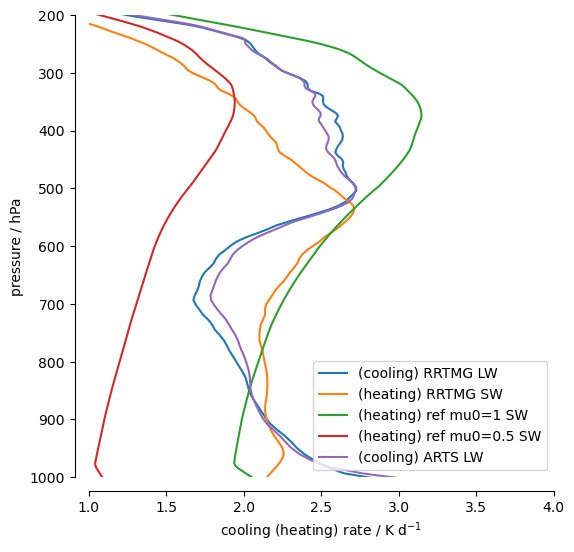

In [6]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(
    -3600 * 24 * flx_rrtmg.lw_htgr.mean("column"),
    flx_rrtmg.pres_level.mean("column") / 100,
    label="(cooling) RRTMG LW",
)
ax.plot(
    3600 * 24 * flx_rrtmg.sw_htgr.where(flx_rrtmg.mu0 > 0).mean("column"),
    flx_rrtmg.where(flx_rrtmg.mu0 > 0).pres_level.mean("column") / 100,
    label="(heating) RRTMG SW",
)

ax.plot(
    3600 * 24 * ref1htg.isel(column=0),
    ref1.pres_level.isel(column=0) / 100,
    label="(heating) ref mu0=1 SW",
)

ax.plot(
    3600 * 24 * ref05htg.isel(column=0),
    ref05.pres_level.isel(column=0) / 100,
    label="(heating) ref mu0=0.5 SW",
)

ax.plot(
    -flx_arts.heating_rate.mean("sonde"),
    flx_arts.p.mean("sonde") / 100,
    label="(cooling) ARTS LW",
)
ax.invert_yaxis()
ax.set_xlim(1, 4)
ax.set_ylim(1000, 200)
ax.set_ylabel("pressure / hPa")
ax.set_xlabel("cooling (heating) rate / K d$^{-1}$")
ax.legend()
sns.despine(offset=10)

In [17]:
swmu = flx_rrtmg.swap_dims({"column": "mu0"}).sortby("mu0")
swmu = swmu.assign(
    mean_p=swmu.pres_level.mean("mu0") / 100,
    mean_ta=swmu.temp_level.mean("mu0"),
)

swmu = (
    swmu.swap_dims({"level": "mean_p"})
    .sortby("mean_p", ascending=False)
    .sel(mean_p=slice(1000, 200))
    .swap_dims({"mean_p": "level"})
)

In [40]:
ta_bins = np.linspace(220, 305, 85)
srtd = (
    (
        histogram(
            swmu.temp_level,
            bins=[ta_bins],
            dim=["level"],
            weights=swmu.sw_htgr * 3600 * 24,
        )
        / histogram(
            swmu.temp_level,
            bins=[ta_bins],
            dim=["level"],
        )
    )
    .interpolate_na(dim="temp_level_bin")
    .rename("sw_htgr")
    .to_dataset()
)

lrtd = (
    (
        histogram(
            swmu.temp_level,
            bins=[ta_bins],
            dim=["level"],
            weights=swmu.lw_htgr * 3600 * 24,
        )
        / histogram(
            swmu.temp_level,
            bins=[ta_bins],
            dim=["level"],
        )
    )
    .interpolate_na(dim="temp_level_bin")
    .rename("lw_htgr")
    .to_dataset()
)


ref1d = histogram(
    ref1.temp_level,
    bins=[ta_bins],
    dim=["level"],
    weights=ref1htg * 3600 * 24,
) / histogram(
    ref1.temp_level,
    bins=[ta_bins],
    dim=["level"],
)
ref05d = histogram(
    ref05.temp_level,
    bins=[ta_bins],
    dim=["level"],
    weights=ref05htg * 3600 * 24,
) / histogram(
    ref05.temp_level,
    bins=[ta_bins],
)

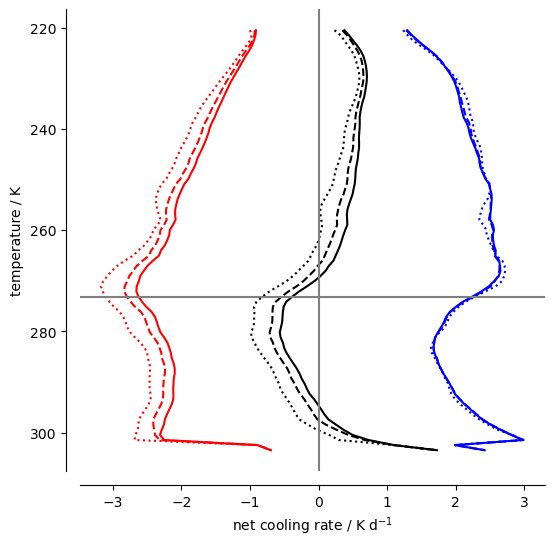

In [41]:
lowmu = 0.9
highmu = None
fig, ax = plt.subplots(figsize=(6, 6))
for lowmu, linestyle in zip([0, 0.5, 0.9], ["-", "--", ":"]):
    (-(lrtd.lw_htgr + srtd.sw_htgr).sel(mu0=slice(lowmu, highmu)).mean("mu0")).plot(
        y="temp_level_bin", ax=ax, color="k", label="Net", linestyle=linestyle
    )
    (-lrtd.lw_htgr.sel(mu0=slice(lowmu, highmu)).mean("mu0")).plot(
        y="temp_level_bin", ax=ax, color="blue", label="LW", linestyle=linestyle
    )
    (-srtd.sw_htgr.sel(mu0=slice(lowmu, highmu)).mean("mu0")).plot(
        y="temp_level_bin", ax=ax, color="red", label="SW", linestyle=linestyle
    )
ax.axvline(0, color="grey", linestyle="-")
ax.invert_yaxis()
ax.set_xlabel("net cooling rate / K d$^{-1}$")
ax.set_ylabel("temperature / K")
ax.axhline(273.15, color="grey", linestyle="-")
sns.despine(offset=10)

<>:26: SyntaxWarning: invalid escape sequence '\m'
<>:40: SyntaxWarning: invalid escape sequence '\m'
<>:44: SyntaxWarning: invalid escape sequence '\m'
<>:67: SyntaxWarning: invalid escape sequence '\m'
<>:26: SyntaxWarning: invalid escape sequence '\m'
<>:40: SyntaxWarning: invalid escape sequence '\m'
<>:44: SyntaxWarning: invalid escape sequence '\m'
<>:67: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_462631/706500640.py:26: SyntaxWarning: invalid escape sequence '\m'
  axes[0, 1].set_xlabel("cosine solar zenith angle ($\mu_0$)")
/tmp/ipykernel_462631/706500640.py:40: SyntaxWarning: invalid escape sequence '\m'
  y=yvar, color="red", label=f"$\mu_0$ > {tup}", ax=axes[1, 0]
/tmp/ipykernel_462631/706500640.py:44: SyntaxWarning: invalid escape sequence '\m'
  y=yvar, color="blue", label=f"$\mu_0$ < {tdown}", ax=axes[1, 0]
/tmp/ipykernel_462631/706500640.py:67: SyntaxWarning: invalid escape sequence '\m'
  axes[1, 1].set_xlabel("sondes (sorted by $\mu_0$)")


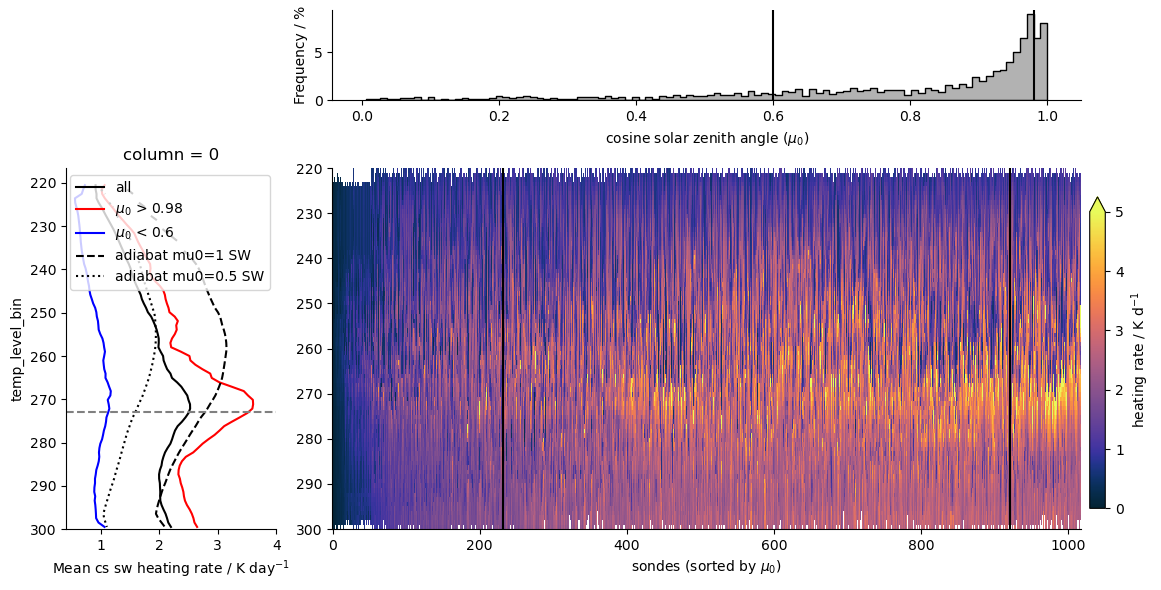

In [221]:
yvar = "temp_level_bin"


fig, axes = plt.subplots(
    2, 2, width_ratios=(0.2, 0.8), height_ratios=(0.2, 0.8), figsize=(12, 6)
)


p = (
    (srtd.where(srtd.mu0 > 0, drop=True).sortby("mu0").sw_htgr)
    .swap_dims({"mu0": "sonde"})
    .plot(
        y=yvar,
        vmin=0,
        vmax=5,
        ax=axes[1, 1],
        cmap="cmo.thermal",
        add_colorbar=False,
        rasterized=True,
    )
)


sns.histplot(
    srtd.mu0.where(srtd.mu0 > 0, drop=True),
    ax=axes[0, 1],
    bins=100,
    stat="percent",
    element="step",
    color="k",
    alpha=0.3,
)
for ax in axes.flatten():
    ax.set_xlabel("")
    ax.set_ylabel("")
axes[0, 1].set_ylabel("Frequency / %")
axes[0, 1].set_xlabel("cosine solar zenith angle ($\mu_0$)")
srtd.sw_htgr.mean("mu0").plot(y=yvar, color="k", label="all", ax=axes[1, 0])
"""
(-lrtd.lw_htgr).mean("mu0").plot(
    y=yvar,color="k", label="LW cooling",linestyle="--", ax=axes[1, 0]
)
"""
tup = 0.98


srtd.sw_htgr.where(srtd.mu0 > tup).mean("mu0").plot(
    y=yvar, color="red", label=f"$\mu_0$ > {tup}", ax=axes[1, 0]
)
tdown = 0.6
srtd.sw_htgr.where(srtd.mu0 < tdown).mean("mu0").plot(
    y=yvar, color="blue", label=f"$\mu_0$ < {tdown}", ax=axes[1, 0]
)

ref1d.plot(y=yvar, label="adiabat mu0=1 SW", color="k", linestyle="--", ax=axes[1, 0])

ref05d.plot(y=yvar, label="adiabat mu0=0.5 SW", color="k", linestyle=":", ax=axes[1, 0])

axes[1, 0].set_xlim(None, 4)
axes[1, 1].axvline((np.abs(srtd.mu0 - tup)).argmin(), color="k", linestyle="-")
axes[1, 1].axvline((np.abs(srtd.mu0 - tdown)).argmin(), color="k", linestyle="-")
axes[0, 1].axvline(tup, color="k", linestyle="-")
axes[0, 1].axvline(tdown, color="k", linestyle="-")

for ax in axes[1, :]:
    ax.invert_yaxis()
    ax.set_ylim(300, None)
axes[1, 0].legend()
axes[1, 0].axhline(273, color="gray", linestyle="--")
axes[1, 0].set_xlabel("Mean cs sw heating rate / K day$^{-1}$")
axes[1, 1].set_xlabel("sondes (sorted by $\mu_0$)")
axes[0, 0].set_visible(False)
sns.despine()
fig.tight_layout()
fig.colorbar(
    p,
    ax=axes[:, 1],
    label="heating rate / K d$^{-1}$",
    pad=0.01,
    fraction=0.1,
    extend="max",
    shrink=0.6,
    anchor=(0, 0.1),
)
fig.savefig("/scratch/m/m301046/mu0_dependence_sw_heating_rate.pdf", dpi=300)